<a href="https://colab.research.google.com/github/heokwon/OCR_Vehicle-registration-plate/blob/main/Car_License_Plate_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xmltodict split-folders easyocr GPUtil
# !pip install split-folders
# !pip install easyocr
# !pip install GPUtil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 619 kB 79.0 MB/s 
     |████████████████████████████████| 145 kB 95.0 MB/s 
     |████████████████████████████████| 47.6 MB 283 kB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=72f999da9379e9107f65a4f151528ca2dfdaeb5e8b74eb2b917c8106b54bb941
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built GPUtil
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [2]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 14245, done.
remote: Total 14245 (delta 0), reused 0 (delta 0), pack-reused 14245
Receiving objects: 100% (14245/14245), 13.50 MiB | 27.11 MiB/s, done.
Resolving deltas: 100% (9810/9810), done.


In [3]:
!pip install -qr /content/yolov5/requirements.txt

     |████████████████████████████████| 182 kB 4.9 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 45.5 MB/s 


In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import cv2
import uuid
import time
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rnd
import splitfolders
import easyocr
import PIL
import copy

from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from timeit import default_timer as timer

import torch

import matplotlib
# matplotlib.use('TkAgg')

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/OCR/Data/kaggle_data.zip /content
!unzip /content/kaggle_data.zip

# 1. Train YOLOv5 to detect car plates

## Prepare the data
### We will use it to describe the pictures and their annotations. First let's define dictionary with the basic informations about the dataset.

In [7]:
dataset = {
            "file":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[]
           }

### Let's explore data a bit. As you can see each image has corresponding file in .xml format that describes it.

In [8]:
img_names = sorted(os.listdir('/content/images'))
annotations = sorted(os.listdir('/content/annotations'))
img_names[:10]

['Cars0.png',
 'Cars1.png',
 'Cars10.png',
 'Cars100.png',
 'Cars101.png',
 'Cars102.png',
 'Cars103.png',
 'Cars104.png',
 'Cars105.png',
 'Cars106.png']

In [9]:
annotations[:10]

['Cars0.xml',
 'Cars1.xml',
 'Cars10.xml',
 'Cars100.xml',
 'Cars101.xml',
 'Cars102.xml',
 'Cars103.xml',
 'Cars104.xml',
 'Cars105.xml',
 'Cars106.xml']

In [ ]:
# img_names=[] 
# annotations=[]
# for dirname, _, filenames in os.walk("kaggle/CV/Plate_recognition/"):
#     for filename in filenames:
#         if os.path.join(dirname, filename)[-3:]==("png" or "jpg"):
#             img_names.append(filename)
#         elif os.path.join(dirname, filename)[-3:]=="xml":
#             annotations.append(filename)
    
# img_names[:10]

['Cars0.png',
 'Cars1.png',
 'Cars10.png',
 'Cars100.png',
 'Cars101.png',
 'Cars102.png',
 'Cars103.png',
 'Cars104.png',
 'Cars105.png',
 'Cars106.png']

In [ ]:
# annotations[:10]

['Cars0.xml',
 'Cars1.xml',
 'Cars10.xml',
 'Cars100.xml',
 'Cars101.xml',
 'Cars102.xml',
 'Cars103.xml',
 'Cars104.xml',
 'Cars105.xml',
 'Cars106.xml']

### Now we can rewrite the info from .xml to our dictionary. Notice that for each photo we can get multiple bonding boxes, therefore filenames, width and height will recur.

In [10]:
path_annotations="/content/annotations/*.xml" 

for item in glob.glob(path_annotations):
    tree = ET.parse(item)
    
    for elem in tree.iter():
        if 'filename' in elem.tag:
            filename=elem.text
        elif 'width' in elem.tag:
            width=int(elem.text)
        elif 'height' in elem.tag:
            height=int(elem.text)
        elif 'xmin' in elem.tag:
            xmin=int(elem.text)
        elif 'ymin' in elem.tag:
            ymin=int(elem.text)
        elif 'xmax' in elem.tag:
            xmax=int(elem.text)
        elif 'ymax' in elem.tag:
            ymax=int(elem.text)
            
            dataset['file'].append(filename)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['xmin'].append(xmin)
            dataset['ymin'].append(ymin)
            dataset['xmax'].append(xmax)
            dataset['ymax'].append(ymax)
        
classes = ['license']

In [11]:
df=pd.DataFrame(dataset)
df

,file,width,height,xmin,ymin,xmax,ymax
0,Cars57.png,431,242,270,162,321,195
1,Cars106.png,400,247,138,79,177,92
2,Cars106.png,400,247,245,79,270,94
3,Cars106.png,400,247,169,202,192,231
4,Cars106.png,400,247,225,194,279,217
...,...,...,...,...,...,...,...
466,Cars139.png,400,300,315,189,337,197
467,Cars139.png,400,300,193,224,231,233
468,Cars403.png,400,320,296,189,332,209
469,Cars403.png,400,320,23,173,54,192


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    471 non-null    object
 1   width   471 non-null    int64 
 2   height  471 non-null    int64 
 3   xmin    471 non-null    int64 
 4   ymin    471 non-null    int64 
 5   xmax    471 non-null    int64 
 6   ymax    471 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 25.9+ KB


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


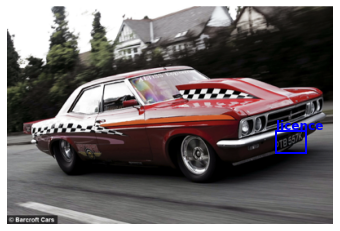

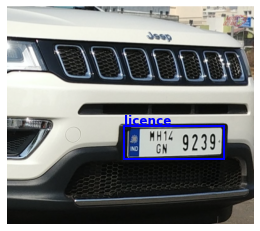

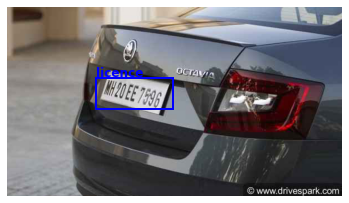

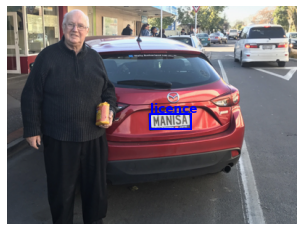

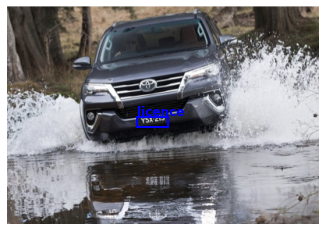

In [13]:
%pylab inline

def print_random_images(photos: list, n: int = 5, seed=None) -> None:
    if n > 10:
        n=10
    
    if seed:
        rnd.seed(seed)
        
    random_photos = rnd.sample(photos, n)
    
    for image_path in random_photos:
        
        with Image.open(image_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)           
            ax.axis(False)
            
            for i, file in enumerate(df.file):
                if file in image_path:
                    x1,y1,x2,y2=list(df.iloc[i, -4:])
                        
                    mpatch=mpatches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1, edgecolor='b',facecolor="none",lw=2,)                    
                    ax.add_patch(mpatch)
                    rx, ry = mpatch.get_xy()
                    ax.annotate('licence', (rx, ry-2), color='blue', weight='bold', fontsize=12, ha='left', va='baseline')
                    
photos_path = "/content/images/*.png"
photos_list = glob.glob(photos_path)

print_random_images(photos_list)

### YOLO model requires normalized data (in range 0 to 1) in format [class_id, x, y, width, height], where x, y are coordinates of the middle of the bounding box(with corresponding width and height). Our calculated data must be saved as a .txt file with a name corresponding to an image. Each .txt file should look like this:
[class_id, x, y, width, height]

[class_id, x, y, width, height]

[class_id, x, y, width, height]

...

In [14]:
x_pos = []
y_pos = []
frame_width = []
frame_height = []

labels_path = Path("/content/labels")

labels_path.mkdir(parents=True, exist_ok=True)

save_type = 'w'

for i, row in enumerate(df.iloc):
    current_filename = str(row.file[:-4])
    
    width, height, xmin, ymin, xmax, ymax = list(df.iloc[i][-6:])
    
    x=(xmin+xmax)/2/width
    y=(ymin+ymax)/2/height
    width=(xmax-xmin)/width
    height=(ymax-ymin)/height
    
    x_pos.append(x)
    y_pos.append(y)
    frame_width.append(width)
    frame_height.append(height)
    
    txt = '0' + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + '\n'
    
    if i > 0:
        previous_filename = str(df.file[i-1][:-4])
        save_type='a+' if current_filename == previous_filename else 'w'
    
    
    with open("/content/labels/" + str(row.file[:-4]) +'.txt', save_type) as f:
        f.write(txt)
        
        
df['x_pos']=x_pos
df['y_pos']=y_pos
df['frame_width']=frame_width
df['frame_height']=frame_height

df

,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos,frame_width,frame_height
0,Cars57.png,431,242,270,162,321,195,0.685615,0.737603,0.118329,0.136364
1,Cars106.png,400,247,138,79,177,92,0.393750,0.346154,0.097500,0.052632
2,Cars106.png,400,247,245,79,270,94,0.643750,0.350202,0.062500,0.060729
3,Cars106.png,400,247,169,202,192,231,0.451250,0.876518,0.057500,0.117409
4,Cars106.png,400,247,225,194,279,217,0.630000,0.831984,0.135000,0.093117
...,...,...,...,...,...,...,...,...,...,...,...
466,Cars139.png,400,300,315,189,337,197,0.815000,0.643333,0.055000,0.026667
467,Cars139.png,400,300,193,224,231,233,0.530000,0.761667,0.095000,0.030000
468,Cars403.png,400,320,296,189,332,209,0.785000,0.621875,0.090000,0.062500
469,Cars403.png,400,320,23,173,54,192,0.096250,0.570312,0.077500,0.059375


## Using splitfolder library we can easily split images images and labels into training and validation sets.

In [15]:
!mkdir ./yolov5/data/Plate_recognition

In [16]:
!mkdir ./Plate_recognition
!mv ./images ./Plate_recognition
!mv ./annotations ./Plate_recognition
!mv ./labels ./Plate_recognition

In [17]:
input_folder = Path("./Plate_recognition")
output_folder = Path("./yolov5/data/Plate_recognition")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)
print("Moving files finished.")

Copying files: 1299 files [00:00, 4351.02 files/s]

Moving files finished.


In [18]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} files in '{dirpath}' folder ")

    
walk_through_dir(input_folder)
print()
walk_through_dir(output_folder)

There are 3 directiories and 0 files in 'Plate_recognition' folder 
There are 0 directiories and 433 files in 'Plate_recognition/images' folder 
There are 0 directiories and 433 files in 'Plate_recognition/annotations' folder 
There are 0 directiories and 433 files in 'Plate_recognition/labels' folder 

There are 2 directiories and 0 files in 'yolov5/data/Plate_recognition' folder 
There are 3 directiories and 0 files in 'yolov5/data/Plate_recognition/train' folder 
There are 0 directiories and 346 files in 'yolov5/data/Plate_recognition/train/images' folder 
There are 0 directiories and 346 files in 'yolov5/data/Plate_recognition/train/annotations' folder 
There are 0 directiories and 346 files in 'yolov5/data/Plate_recognition/train/labels' folder 
There are 3 directiories and 0 files in 'yolov5/data/Plate_recognition/val' folder 
There are 0 directiories and 87 files in 'yolov5/data/Plate_recognition/val/images' folder 
There are 0 directiories and 87 files in 'yolov5/data/Plate_rec

## Yolo requires config data in .yaml file. You can explore yolov5 directory to see how should it look like. 

In [19]:
import yaml

yaml_file = './yolov5/data/plates.yaml'

yaml_data = dict(
    path = "data/Plate_recognition",
    train = "train",
    val = "val",
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)

## *(Optional)* Clear the gpu memory

In [20]:
def free_gpu_cache() -> None:
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  4% |  1% |


In [21]:
device = '0' if torch.cuda.is_available() else 'cpu' 
device

'0'

## Train the model!
## For model installation and required downloads check this: https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data

In [22]:
start_time = timer()

!cd yolov5 && python train.py --workers 2 --img 640 --batch 16 --epochs 100 --data "data/plates.yaml" --weights yolov5s.pt --device {device} --cache

end_time = timer()

print(f'Training time: {(end_time-start_time):.2f}')

train: weights=yolov5s.pt, cfg=, data=data/plates.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-12-g7f5724b Python-3.8.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=

# 2. Use evaluated model to detect plates frame by frame in a video
## Load trained weights to the model

In [26]:
!cp /content/yolov5/runs/train/exp/weights/best.pt /content/drive/MyDrive/OCR/Weights

In [24]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path = 'yolov5/runs/train/exp/weights/best.pt', force_reload=True)

reader = easyocr.Reader(['en'])

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-12-1 Python-3.8.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [25]:
def get_plates_xy(frame: np.ndarray, labels: list, row: list, width: int, height: int, reader: easyocr.Reader) -> tuple:
    '''Get the results from easyOCR for each frame and return them with bounding box coordinates'''
    
    x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height) ## BBOx coordniates
    plate_crop = frame[int(y1):int(y2), int(x1):int(x2)]
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) ## BBox
    ocr_result = reader.readtext(np.asarray(plate_crop), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')#, paragraph="True", min_size=50)
    
    return ocr_result, x1, y1


def detect_text(i: int, row: list, x1: int, y1: int, ocr_result: list, detections: list, yolo_detection_prob: float=0.3) -> list:
    '''Checks the detection's probability, discards those with low prob and rewrites output from ocr_reader to >>detections<< list'''
    
    if row[4] >= yolo_detection_prob: #discard predictions below the value             
        if(len(ocr_result))>0:
            for item in ocr_result:     
                    detections[i][0]=item[1]
                    detections[i][1]=[x1, y1]
                    detections[i][2]=item[2]
                    
    return detections


def is_adjacent(coord1: list, coord2: list) -> bool:
    '''Checks if [x, y] from list coord1 is similar to coord2'''
    
    MAX_PIXELS_DIFF=50
    
    if (abs(coord1[0] - coord2[0]) <= MAX_PIXELS_DIFF) and (abs(coord1[1] - coord2[1]) <= MAX_PIXELS_DIFF):
        return True
    else:
        return False
    

def sort_detections(detections: list, plates_data: list) -> list:
    '''Looks at detections from last frame and rewrites indexes for similar coordinates'''
    
    for m in range(0, len(detections)):
        for n in range(0, len(plates_data)):
            if not detections[m][1]==[0, 0] and not plates_data[n][1]==[0,0]:
                if is_adjacent(detections[m][1], plates_data[n][1]):
                    if m!=n:
                        temp=detections[m]
                        detections[m]=detections[n]
                        detections[n]=temp
                        
    return detections


def delete_old_labels(detections: list, count_empty_labels: list, plates_data: list, frames_to_reset: int=3) -> tuple:
    '''If earlier detected plate isn't spotted for the next >>FRAMES_TO_RESET<< frames, delete it from >>plates_data<<'''
    
    for m in range(0, len(detections)):
        if detections[m][0]=='None' and not count_empty_labels[m]==frames_to_reset:
            count_empty_labels[m]+=1
        elif count_empty_labels[m]==frames_to_reset:
            count_empty_labels[m]=0
            plates_data[m]=['None', [0,0], 0]
        else:
            count_empty_labels[m]=0
            
    return plates_data, count_empty_labels


def overwrite_plates_data(detections: list, plates_data: list, plate_lenght=None) -> list:
    '''Checks coordinates from >>detections<<, if there is similar record in >>plate_data<< tries to overwrite it (only if probability is higher)'''
    
    if (detections[i][2]>plates_data[i][2] or detections[i][2]==0):
        if plate_lenght:
            if len(detections[i][0])==plate_lenght:
                plates_data[i][0]=detections[i][0]
                plates_data[i][2]=detections[i][2]       
        else:
            plates_data[i][0]=detections[i][0]
            plates_data[i][2]=detections[i][2]
    plates_data[i][1]=detections[i][1]
        
    return plates_data

## Points 3, 4, 5 are executed for each frame of the video. The functions used here are described one cell above.

In [ ]:
video_path = "/content/Plate_recognition/Sample_video.mp4"
cap = cv2.VideoCapture(video_path)

plates_data = [['None', [0,0], 0] for n in range(5)]
count_empty_labels=[0]*5

assert cap.isOpened()

while(cap.isOpened()):
    ret, frame = cap.read()
    assert not isinstance(frame,type(None)), 'frame not found'
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)    
    results = model(frame)   
    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
    
    labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
    width, height = frame.shape[1], frame.shape[0]
    
    detections=[['None', [0,0], 0] for n in range(5)]
    i=0 
    
    
    ## Read all detected plates per each frame and save them to >>detections<<
    while i < len(labels):    
        row = coordinates[i]
        ## 3. Crop detections and pass them to the easyOCR
        ocr_result, x1, y1=get_plates_xy(frame, labels, row, width, height, reader)  
        
        ## 4. Get reading for the each frame
        detections=detect_text(i, row, x1, y1, ocr_result, detections, 0.5)
        i+=1    
    i=0
    
    ## 5. Do some tracking and data managing for better results
    ## If we get multiple detections in one frame easyOCR mixes them every few frames, so here we make sure that they are saved according to the \
    ## detections' coordinates. Then we delete data about plates that dissapeared for more than >>frames_to_reset<< frames. And finally we overwrite \
    ## the predictions (regarding to the probability of easyOCR detections - if new predcition has less p% than the previous one, we skip it.)
    
    ## Sort detections 
    detections=sort_detections(detections, plates_data)
    
    ## Delete data about plates that dissapeared from frame
    plates_data, count_empty_labels=delete_old_labels(detections, count_empty_labels, plates_data, 3)
            
    ## Overwrite data and print text predictions over the boxes
    while i < len(labels):
        plates_data=overwrite_plates_data(detections, plates_data, 7)
        cv2.putText(frame, f"{plates_data[i][0]}", (plates_data[i][1]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
        i+=1
    
    cv2.imshow('YOLO & OCR', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

## We can also use our model to read plates from the photos

Photo width,height: 2048,1536. Detected plates: 1

Detection: 1. YOLOv5 prob: 0.90, easyOCR results: [[[[25, -4], [329, -4], [329, 126], [25, 126]], 'CB 38947']]


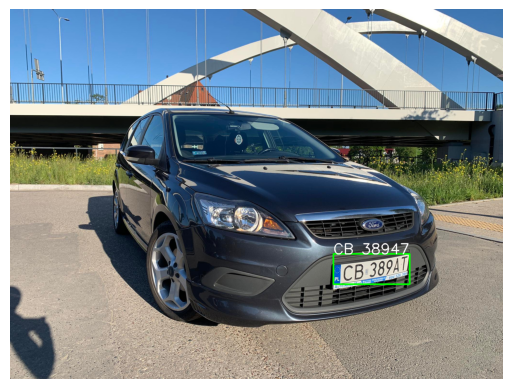

In [ ]:
%matplotlib inline

test_photo_path = "/content/Plate_recognition/Sample_photo2.jpg"

results = model(test_photo_path)
detections=np.squeeze(results.render())

labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
image = cv2.imread(test_photo_path)
width, height = image.shape[1], image.shape[0]

print(f'Photo width,height: {width},{height}. Detected plates: {len(labels)}')

for i in range(len(labels)):
    row = coordinates[i]
    if row[4] >= 0.6:
        x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height)
        plate_crop = image[int(y1):int(y2), int(x1):int(x2)]
        ocr_result = reader.readtext((plate_crop), paragraph="True", min_size=120, allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        text=ocr_result[0][1]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 6) ## BBox
        cv2.putText(image, f"{text}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
        plt.axis(False)
        plt.imshow((image)[...,::-1])
        
        print(f'Detection: {i+1}. YOLOv5 prob: {row[4]:.2f}, easyOCR results: {ocr_result}')